In [7]:
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
import sys
sys.path.append("../")
from param_dataset import *
from datasets import *

from robustbench.utils import clean_accuracy
from robustbench.utils import load_model
from torch.utils.data import DataLoader
import torch.nn as nn
sys.path.append("../finetuning")
from finetuning.train import validate
import matplotlib.pyplot as plt

def put_back_params(model,params):
    with torch.no_grad():
        weights = params[:len(params)//2]
        biases = params[len(params)//2:]
        model.bn1.weight[:] = weights[:]
        model.bn1.bias[:] = biases[:]
        return model

model = Unet1D(
        dim = 16,
        dim_mults = (1, 2, 2, 2),
        channels = 8
    )

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 160,
    timesteps = 1000,
    objective = 'pred_noise',
    auto_normalize=False,
    beta_schedule='linear'
)

root_path = os.path.expanduser(f"~/Projects/GenAIProject/saved_data/checkpoints/gen_last_bn_eval_diverse/contrast")
dataset = ParamDataset(root_path)

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 64,
    train_lr = 4e-3,
    train_num_steps = 5000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    corr='contrast',
    results_folder='test'
)

/home/gc28692/anaconda3/envs/ttda/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


In [8]:
corrs = ["frost", "gaussian_noise", "glass_blur", "contrast", "pixelate"]
ts = np.array([1,2,4,8,16,32,64,128,256,512,999])
accs = np.zeros((len(corrs),3,len(ts)))

for corr_i, corr in enumerate(corrs):
    print(corr)
    root_path = os.path.expanduser(f"~/Projects/GenAIProject/saved_data/checkpoints/gen_last_bn_eval_diverse/{corr}")
    dataset = ParamDataset(root_path)
    for itr in range(3):
        print(itr)
        for t_i,t in enumerate(ts):
            x_start = dataset[0].unsqueeze(0)
            x_noisy = diffusion.q_sample(x_start.to('cuda'),torch.tensor([t]).to('cuda'))
            model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval()
            model = put_back_params(model,x_noisy.view(-1))
            model = model.eval()
            # train_ds, val_ds, test_ds = get_cifar10c_data([dls.vocab[yb[0]]],1000)
            train_ds, val_ds, test_ds = get_cifar10c_data([corr],1000)
            dl_t = DataLoader(test_ds,batch_size=256)
            criterion = nn.CrossEntropyLoss()

            acc, loss = validate(model,dl_t,'cuda',criterion)
            
            accs[corr_i,itr,t_i] = acc

frost
0


100%|██████████| 35/35 [00:03<00:00,  9.66it/s]


1


100%|██████████| 35/35 [00:03<00:00,  9.64it/s]


2


100%|██████████| 35/35 [00:03<00:00,  9.61it/s]


gaussian_noise
0


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


1


100%|██████████| 35/35 [00:03<00:00,  9.59it/s]


2


100%|██████████| 35/35 [00:03<00:00,  9.59it/s]


glass_blur
0


100%|██████████| 35/35 [00:03<00:00,  9.59it/s]


1


100%|██████████| 35/35 [00:03<00:00,  9.59it/s]


2


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


contrast
0


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


1


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


2


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


pixelate
0


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


1


100%|██████████| 35/35 [00:03<00:00,  9.60it/s]


2


100%|██████████| 35/35 [00:03<00:00,  9.59it/s]


In [9]:
np.save("accs_add_noise_lin.npy",accs)

In [18]:
accs = np.load("accs_add_noise.npy")

Text(0, 0.5, 'Test Accuracy')

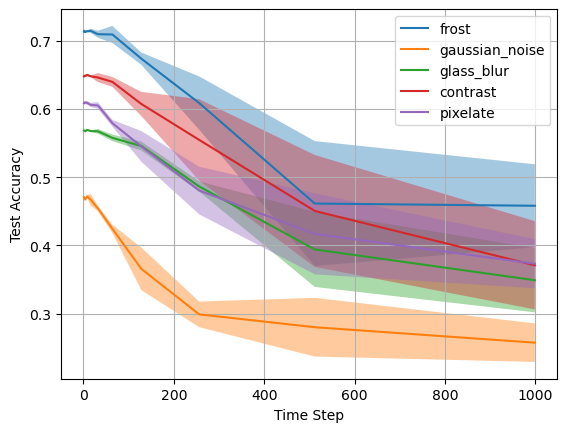

In [19]:
fig,ax = plt.subplots(1,1)
for corr_i, corr in enumerate(corrs):
    mean_acc = accs[corr_i,:,:].mean(axis=0)
    std_acc = accs[corr_i,:,:].std(axis=0)
    ax.plot(ts,mean_acc,label=corr)
    ax.fill_between(ts,mean_acc-std_acc,mean_acc+std_acc,alpha=0.4)
ax.legend()
ax.grid()
ax.set_xlabel("Time Step")
ax.set_ylabel("Test Accuracy")

In [20]:
fig.savefig('cos.pdf')

In [76]:
trainer.load(3)

loading from version 1.11.0


In [85]:
sampled_seq = trainer.model.sample(batch_size = 4)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [78]:
import matplotlib.pyplot as plt

In [87]:
root_dir = '../saved_data/checkpoints/gen_last_bn_eval_diverse/frost'
files = os.listdir(root_dir)
ck = torch.load(os.path.join(root_dir,files[0]))

vec = torch.cat([param.flatten() for param in ck['model_state_dict'].values()]).to('cpu')
vecs = torch.zeros(100,vec.shape[0])
for i in range(100):
    ck = torch.load(os.path.join(root_dir,files[i]))
    vecs[i,:] = torch.cat([param.flatten() for param in ck['model_state_dict'].values()]).to('cpu')

(array([  1.,   0.,   0.,   1.,   2.,   6.,   9.,  10.,  36.,  28.,  44.,  66.,  94., 127., 115.,  79.,  57.,  66.,  76.,  57.,  69.,  56.,  63.,  41.,  46.,  42.,  24.,  21.,  10.,   9.,   5.,   6.,   8.,   3.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.3614144 , -0.33802626, -0.31463808, -0.29124993, -0.26786175, -0.24447361, -0.22108544, -0.19769728, -0.17430912, -0.15092096, -0.12753281, -0.10414464, -0.08075649, -0.05736832, -0.03398016, -0.010592  ,  0.01279616,  0.03618432,  0.05957248,  0.08296064,  0.1063488 ,  0.12973696,  0.15312512,  0.17651328,  0.19990143,  0.22328959,  0.24667776,  0.2700659 ,  0.29345408,  0.31684223,  0.34023041,  0.36361855,  0.38700673,  0.41039488,  0.43378302,  0.4571712 ,  0.48055935,  0.5039475 ,  0.5273357 ,  0.55072385,  0.574112  ]),
 <BarContainer object of 40 artists>)

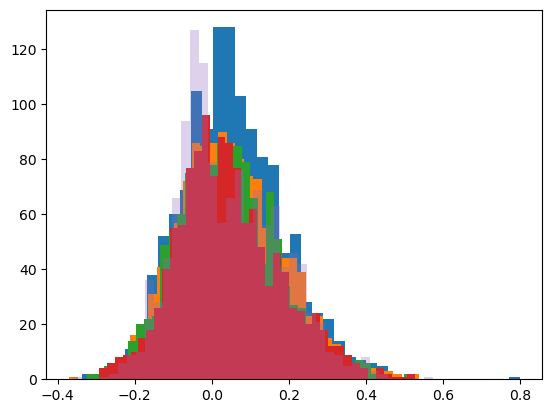

In [91]:
plt.hist(sampled_seq[0].view(-1).cpu(),bins=40)
plt.hist(sampled_seq[1].view(-1).cpu(),bins=40)
plt.hist(sampled_seq[2].view(-1).cpu(),bins=40)
plt.hist(sampled_seq[3].view(-1).cpu(),bins=40)
plt.hist(vecs[10],bins=40,alpha=0.3)

In [92]:
sampled_seq[0].view(-1)

tensor([-0.1924,  0.0632, -0.1144,  ...,  0.0514, -0.0079, -0.1094],
       device='cuda:0')

In [70]:
vecs[0]

tensor([-0.0016, -0.1264, -0.0696,  ...,  0.0540, -0.0194,  0.0212])

In [93]:
from robustbench.utils import clean_accuracy
from robustbench.utils import load_model
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
sys.path.append("../")
sys.path.append("../finetuning")
from finetuning.datasets import *
from finetuning.train import validate

def put_back_params(model,params):
    with torch.no_grad():
        weights = params[:len(params)//2]
        biases = params[len(params)//2:]
        model.bn1.weight[:] = weights[:]
        model.bn1.bias[:] = biases[:]
        return model

model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval()
model = put_back_params(model,sampled_seq[2].view(-1))
# model.load_state_dict(sd,strict=False)
model = model.eval()
# train_ds, val_ds, test_ds = get_cifar10c_data([dls.vocab[yb[0]]],1000)
train_ds, val_ds, test_ds = get_cifar10c_data(['frost'],1000)
dl_t = DataLoader(test_ds,batch_size=256)
criterion = nn.CrossEntropyLoss()

validate(model,dl_t,'cuda',criterion)

/home/gc28692/Projects/GenAIProject/finetuning/datasets.py:29: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(labels[i])
100%|██████████| 35/35 [00:05<00:00,  5.89it/s]


(0.6943181818181818, tensor(1.0272, device='cuda:0'))

In [95]:
s1 = sampled_seq[0].view(-1)
s2 = sampled_seq[1].view(-1)
s3 = sampled_seq[2].view(-1)
s4 = sampled_seq[3].view(-1)

In [111]:
torch.cosine_similarity(vecs.cpu(),s4.unsqueeze(0).cpu())

tensor([0.2849, 0.2996, 0.2876, 0.2839, 0.2584, 0.2603, 0.2551, 0.2914, 0.2396,
        0.2694, 0.2896, 0.2175, 0.2482, 0.2698, 0.2468, 0.2662, 0.2798, 0.2706,
        0.2397, 0.2686, 0.1714, 0.2662, 0.2602, 0.2337, 0.2508, 0.2553, 0.2424,
        0.2688, 0.2271, 0.2428, 0.2494, 0.2220, 0.2482, 0.2703, 0.2501, 0.2844,
        0.3392, 0.3046, 0.1293, 0.2357, 0.2934, 0.2953, 0.2802, 0.2662, 0.3275,
        0.2892, 0.2915, 0.2824, 0.2572, 0.2799, 0.2446, 0.2338, 0.3097, 0.2856,
        0.2453, 0.2587, 0.2691, 0.2809, 0.2078, 0.2641, 0.2759, 0.2441, 0.2316,
        0.1806, 0.2168, 0.2588, 0.2163, 0.2911, 0.2875, 0.2666, 0.2654, 0.2163,
        0.2550, 0.1952, 0.2447, 0.2653, 0.2618, 0.2140, 0.2894, 0.2609, 0.1982,
        0.2484, 0.2636, 0.3095, 0.2500, 0.2965, 0.2516, 0.2934, 0.2193, 0.2335,
        0.2751, 0.3062, 0.2209, 0.2568, 0.2742, 0.2685, 0.2875, 0.2840, 0.2782,
        0.2687])

In [116]:
sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)/1000000

14.869264

In [115]:
sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000

36.479194